<hr>

This is the notes that I took following [this lecture](https://learn.deeplearning.ai/courses/embedding-models-from-architecture-to-implementation).

It talks about training and using embedding models for RAG applications.

I hope this will be helpful!

<hr>

## Contextualised Token Embeddings

### Introduction

We talk about contextualised token embeddings like BERT here.

These models are different from **word embedding models**,  like `word2vec` or `GloVe`, which generate a vector for each _word_. 

For the **word embedding models**, the **context** is lost. Contextualised embedding models made improevments.

#### BERT

Bert is a model with transformer--like architecture. 

- A full transformer have an `encoder` and one `decoder`.
- GPTs are decoder only.
- Bert is encoder only.

Bert base

- 12 layers
- 768 hidden units
- 12 attention heads
- 110 Million parameters

Bert large

- 24 layers
- 1024 hidden units
- 16 attention heads
- 340 Millon parameters

#### Training Bert

The pretraining of bert contains the following steps.

1. Masked language modelling (MLM), where the model is trained to predict a randomly masked missing word.
2. Next sentence prediction (NSP), where the model is trained to predict the next (short) sentence.

After this, we often finetune the model for specialised downstream tasks:

- text classification
- named entity recognisation
- question answering

Here is an example

```{mermaid}
graph TD;
    A[sentence A] --> B[Bert];
    S[SEP token] --> B;
    C[sentence B] --> B;
    B --> CLS[classifier];
```

#### CLS token in Bert

Q: Is it true that the CLS token is inserted to the beginning of the text by all tokenizers?

A: The statement that the CLS (Classification) token is inserted at the beginning of the text by all tokenizers is not entirely accurate. Here's a more precise explanation:

- **BERT and Similar Models:** The CLS token is a special token used in transformer models like BERT (Bidirectional Encoder Representations from Transformers). In these models, the CLS token is indeed inserted at the beginning of the input text during tokenization. This token serves as a summary representation of the entire input sequence, often used in classification tasks.

- **Other Models:** Not all tokenizers or models use the CLS token. The insertion of the CLS token is specific to certain models like BERT, RoBERTa, and some other models derived from the transformer architecture that use this token for specific purposes.

- **BERT:** When BERT tokenizes a text, it inserts the CLS token at the beginning and, often, a SEP (Separator) token at the end (especially when handling pairs of sentences).

- **GPT:** Models like GPT (Generative Pre-trained Transformer) do not use a CLS token. Instead, they might use different special tokens or none at all, depending on the specific task or model configuration.

In summary, the CLS token is not universally inserted at the beginning of the text by all tokenizers. It is specific to models like BERT and its variants, where it plays a particular role in processing input sequences. Other models might use different conventions or special tokens.

### GloVe: word embedding

We start showing how a word embedding model works. Here is the example with `GloVe` model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

We use the `gensim` library to download and use the word--embedding models.

In [2]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')

The `word_vectors` is a model and we can use it to process individual words as if it is a Python `dict`.

In [3]:
print(word_vectors['king'].shape)
print(word_vectors['king'][:5])

(100,)
[-0.32307 -0.87616  0.21977  0.25268  0.22976]


Here are the visualization for some words with PCA.

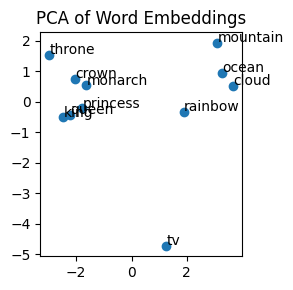

In [4]:
words = [
    "king", "princess", "monarch", "throne", "crown", 
    "mountain", "ocean", "tv", "rainbow", "cloud", "queen"
]
vectors = np.array([word_vectors[word] for word in words])
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
axes.set_title('PCA of Word Embeddings')
plt.tight_layout()
plt.show()

Here are the algebraic relationships for the words.

In [5]:
result = word_vectors.most_similar(
    positive=['king', 'woman'], 
    negative=['man'], topn=1
)

print(
    f"""
    The word closest to 'king' - 'man' + 'woman' is: '{result[0][0]}' 
    with a similarity score of {result[0][1]}"""
)


    The word closest to 'king' - 'man' + 'woman' is: 'queen' 
    with a similarity score of 0.7698540091514587


### GloVe vs BERT: words in context

#### Download the models

To make the note run, we need to download these models to a directory named `models`.

- bert-base-uncased: https://huggingface.co/google-bert/bert-base-uncased
- dpr-ctx_encoder-multiset-base: https://huggingface.co/facebook/dpr-ctx_encoder-multiset-base
- dpr-question_encoder-multiset-base: https://huggingface.co/facebook/dpr-question_encoder-multiset-base

The way to actually download these models are

1. Install Git-LFS
2. Use `git clone URL` to download the files.

The hierarchy of the model directory is,

```sh
.
├── bert-base-uncased
└── facebook
    ├── dpr-ctx_encoder-multiset-base
    └── dpr-question_encoder-multiset-base
```

#### Code

Here we load the downloaded Bert model and we print out its architecture. On a high level, its made of

```{mermaid}
---
title: Bert Architecture
---
flowchart LR
    X([Tokens]) --> Embeddings --> Encoders --> Linear --> Y([Output]);
```

In [6]:
tokenizer = BertTokenizer.from_pretrained('./models/bert-base-uncased')
model = BertModel.from_pretrained('./models/bert-base-uncased')
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [7]:
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    return word_embedding

Here we show that the same word (bat) have different encodings in different sentences.

In [8]:
sentence1 = "The bat flew out of the cave at night."
sentence2 = "He swung the bat and hit a home run."

word = "bat"

bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vectors[word]

print("BERT Embedding for 'bat' in sentence 1:", bert_embedding1[:5])
print("BERT Embedding for 'bat' in sentence 2:", bert_embedding2[:5])
print("GloVe Embedding for 'bat':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")

BERT Embedding for 'bat' in sentence 1: [ 0.41316125 -0.12908228 -0.4486571  -0.40492678 -0.15305704]
BERT Embedding for 'bat' in sentence 2: [ 0.64066917 -0.31121528 -0.4408981  -0.16551168 -0.20056099]
GloVe Embedding for 'bat': [-0.47601  0.81705  0.11151 -0.22687 -0.80672]

Cosine Similarity between BERT embeddings in different contexts: 0.45995745062828064
Cosine Similarity between GloVe embeddings: 1.0


### Cross Encoder

Bert is a general LM and here we demonstrated anoter model that has been finetuned on Question--Answer pairs.

More details can be found [here](https://sbert.net/docs/quickstart.html#cross-encoder).

This model can even be used as a QA bot.

In [9]:
from sentence_transformers import CrossEncoder
model = CrossEncoder(
    'cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512, 
    default_activation_function=torch.nn.Sigmoid()
)

In [10]:
question = "Where is the capital of France?"

answers = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain."
]

In [11]:
scores = model.predict([
    (question, answers[0]),
    (question, answers[1]),
    (question, answers[2])
])
print(scores)
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant passage is: {answers[most_relevant_idx]}")

[0.99965715 0.05289626 0.04520707]
The most relevant passage is: Paris is the capital of France.


## Token v.s. Sentence Embedding

### Two levels of Embeddings

The tokens in BERT model are embedded in two stages:

1. token level embedding.
2. context level embedding.

Here is an illustration.

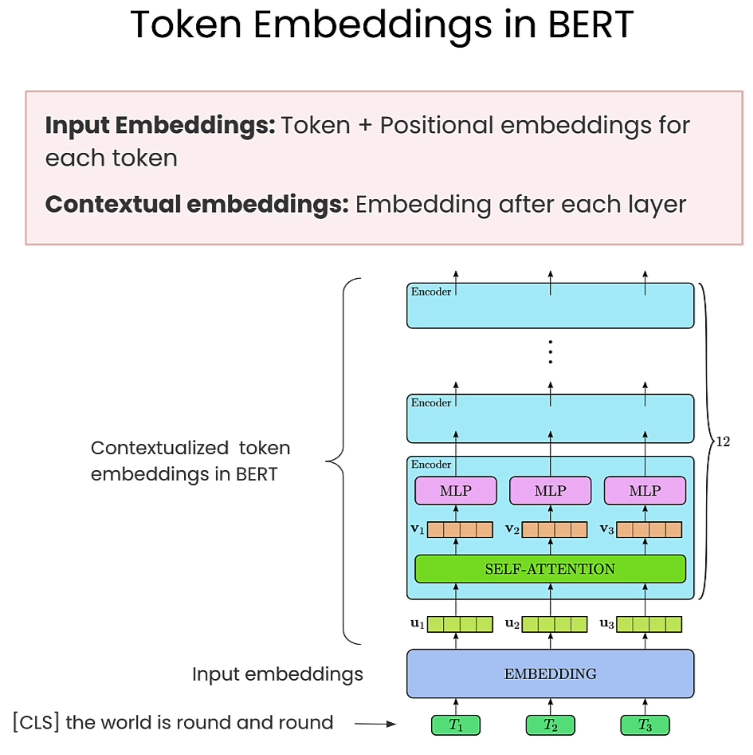

### Creating Embeddings for Sentences.

The idea: to create an embedding for **sentences**, rather than words / tokens?

We want to capture semantic similarities between sentences.

Naive approaches that fail:

- (Mean pooling) To take the output of the last layer of the transformer model, and average over different tokens.
- Just use the embedding of the `CLS` special token.

### Approach #1: Mean Pooling

Let's see the code

In [12]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

from transformers import BertModel, BertTokenizer
from datasets import load_dataset

Now we try the mean pooling method.

<Axes: title={'center': 'Semantic Textual Similarity'}>

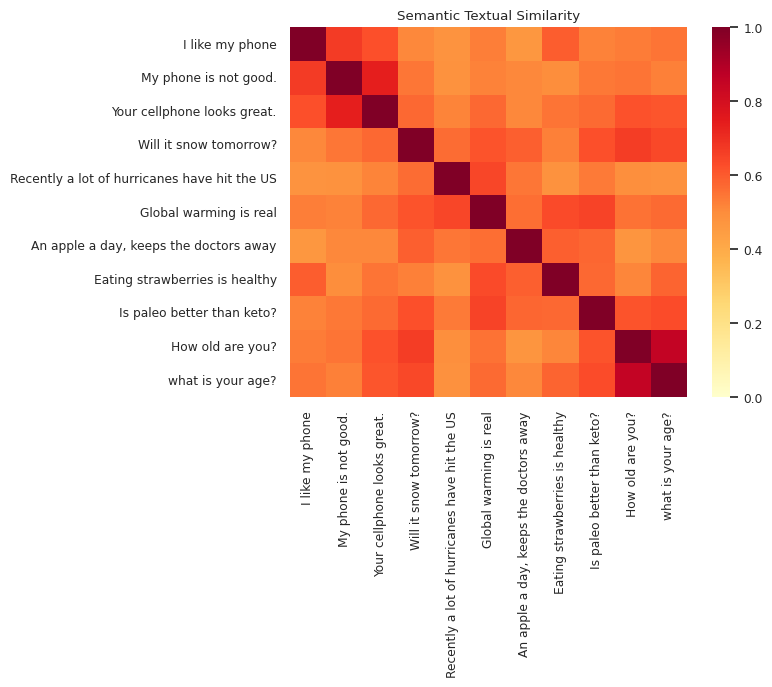

In [13]:
def get_sentence_embedding(sentence):
    """
    """
    encoded_input = tokenizer(
        sentence, padding=True, truncation=True, return_tensors='pt'
    )
    attention_mask = encoded_input['attention_mask']

    with torch.no_grad():
        output = model(**encoded_input)

    token_embeddings = output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(
        token_embeddings.size()
    ).float()

    # mean pooling operation, considering the BERT input_mask and padding
    sentence_embedding = torch.sum(
        token_embeddings * input_mask_expanded, 1
    ) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )
    return sentence_embedding.flatten().tolist()

def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    return rounded_similarity_matrix

def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=0.8)
    g = sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

model_name = "./models/bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

embeddings = []
for t in messages:
    emb = get_sentence_embedding(t)
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)

The result is not good. Now we benchmark the method with a standard dataset.

Here the scores are generated by human benchmarks.

In [14]:
sts_dataset = load_dataset("mteb/stsbenchmark-sts")
sts = pd.DataFrame({'sent1': sts_dataset['test']['sentence1'], 
                    'sent2': sts_dataset['test']['sentence2'],
                    'score': [x/5 for x in sts_dataset['test']['score']]})
sts.head(10)

,sent1,sent2,score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400
4,A man is playing a harp.,A man is playing a keyboard.,0.3000
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000
7,A man is playing the drums.,A man is playing the guitar.,0.4400
8,A man is playing guitar.,A lady is playing the guitar.,0.4400
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428


In [15]:
def sim_two_sentences(s1, s2):
    emb1 = get_sentence_embedding(s1)
    emb2 = get_sentence_embedding(s2)
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

n_examples = 50

sts = sts.head(n_examples)
sts['avg_bert_score'] = np.vectorize(sim_two_sentences) \
                                    (sts['sent1'], sts['sent2'])

In [16]:
sts.head(10)

,sent1,sent2,score,avg_bert_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588


The result of the mean pooling method gives very high similarity scores for all samples. This is not good.

We can use the Pearson Correlation to quantify the effect:

In [17]:
pc = scipy.stats.pearsonr(sts['score'], sts['avg_bert_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.32100172202695454
p-value = 0.02303013509739929


### Approach #2: Sentence Transformer

<Axes: title={'center': 'Semantic Textual Similarity'}>

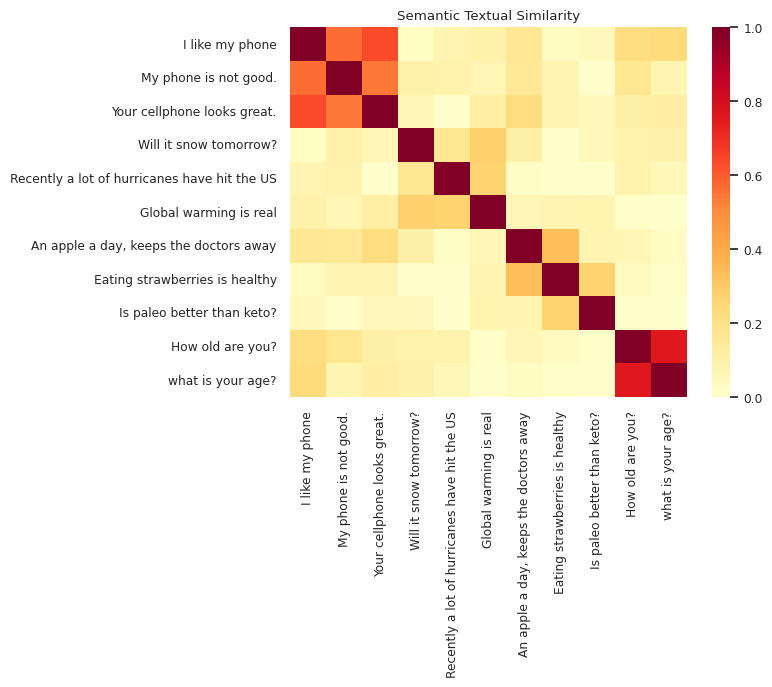

In [18]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = []
for t in messages:
    emb = list(model.encode(t))
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)

In [19]:
def sim_two_sentences(s1, s2):
    emb1 = list(model.encode(s1))
    emb2 = list(model.encode(s2))
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

sts['mini_LM_score'] = np.vectorize(sim_two_sentences)(sts['sent1'], sts['sent2'])
sts.head(10)

,sent1,sent2,score,avg_bert_score,mini_LM_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767,0.8052
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615,0.7886
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191,0.9465
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763,0.8820
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472,0.3556
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787,0.5017
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793,0.8074
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730,0.4757
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519,0.6182
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588,0.5096


Now we calculate the Pearson correlation score again, it is much higher!

In [20]:
pc = scipy.stats.pearsonr(sts['score'], sts['mini_LM_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.9303740673726044
p-value = 1.4823857251915091e-22


### History of Sentence Transformers

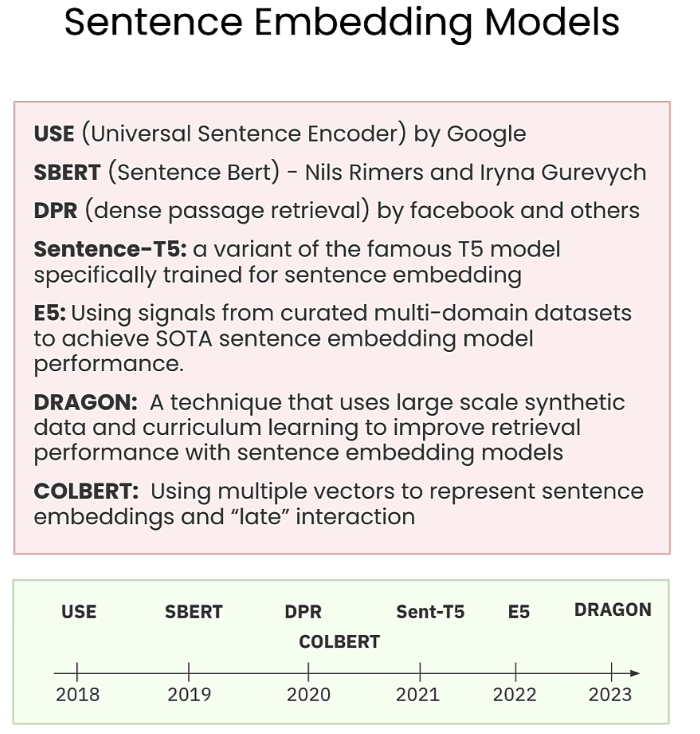

### Different Tasks for Sentence Transformers

1. Similarity Calculation
2. Question Answering

For the QA task, we have two encoders for both Q and A, and they are trained with contrasive loss function.

## Training a Dual Encoder

Here we will

1. Build a dual encoder, and
2. Train the encoder with Q+A pairs

### Dual Encoder

```{mermaid}
flowchart LR
    Q[What is the tallest mountain?]
    A[Mount Everest]
    EQ([Question Encoder])
    EA([Answer Encoder])
    VQ{{Question Embedding Vector}}
    VA{{Answer Embedding Vector}}
    DOT(Dot-product similarity)
    Q --> EQ --> VQ --> DOT
    A --> EA --> VA --> DOT
```

We train this model with contrasive loss:

$$
\mathcal{L} = \sum_{ij} \left[
y_{ij} \cdot \left(
    1 - \underbrace{\textrm{sim}(u_i, v_j)}_\textrm{larger = better}
\right)^2 +\
(1 - y_{ij}) \cdot \underbrace{
    \max\left(0,\; \textrm{sim}(u_i, v_j) - m \right)^2
}_\textrm{should be smaller than m}
\right]
$$

where

- $y_{ij} = 1$ when the question $i$ and answer $j$ matches.
- $u_i$ is the question embedding vector.
- $v_j$ is the answer embedding vector.
- $m$ is the minimum acceptable distance.

In [21]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

### The Cross-Entropy Trick

Here we demonstrate the usage of cross entropy

$$
\frac{1}{N} \sum_{i=1}^{N} \log \left(
\frac{\exp{S_{ii}}}{\sum_{j=1}^N \exp(S_{ij})}
\right)
$$

for (a special kind of) contrasive loss calculation. This loss function works well.

Notice that,

- Pytorch takes the **logits** so the softmax is performed during the loss calculation.
- We are effectively treating the similarity of Question $i$ vs Answer $j$, as the logit (probability) of sample $i$ being in class $j$.
- I think the cross entropy is a surgate to the contrasive loss. But why don't we optimise the contrasive loss directly?

In [22]:
def contrastive_loss(data):
    target = torch.arange(data.size(0))  # (N, )
    loss = torch.nn.CrossEntropyLoss()(data, target)
    return loss

df = pd.DataFrame(
    [
        [4.3, 1.2, 0.05, 1.07],
        [0.18, 3.2, 0.09, 0.05],
        [0.85, 0.27, 2.2, 1.03],
        [0.23, 0.57, 0.12, 5.1]
    ]
)
data = torch.tensor(df.values, dtype=torch.float32)
loss = contrastive_loss(data)
print(loss)

tensor(0.1966)


Here we show that the more "diagnal" the result is, the smaller the loss value.

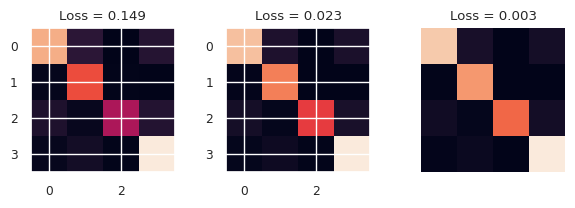

In [23]:
N = data.size(0)
non_diag_mask = ~torch.eye(N, N, dtype=bool)

fig, axes = plt.subplots(1, 3, figsize=(6, 2))
for inx in range(3):
    data = torch.tensor(df.values, dtype=torch.float32)
    data[range(N), range(N)] += inx * 2
    data[non_diag_mask] /= 2
    axes[inx].set_title(f"Loss = {contrastive_loss(data):.3f}")
    axes[inx].imshow(data)
plt.axis('off')
plt.tight_layout()
plt.show()

### The Encoder

```{mermaid}
flowchart LR
    IN([Input Tokens\nBS * L])
    X1([BS * L * 512])
    X2([BS * L * 512])
    C([CLS\nBS * 512])
    Y([Contextualised\nEmbedding\nBS * 128])
    EB[Embedding]
    TE[Encoder]
    PJ[Linear]

    IN --> EB --> X1 --> TE --> X2 -- Slice --> C --> PJ --> Y
```

In [24]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim_in, embed_dim_out):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim_in)
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model=embed_dim_in,
                nhead=8,
                batch_first=True,
            ),
            num_layers=3,
            norm=torch.nn.LayerNorm(normalized_shape=[embed_dim_in,]),
            enable_nested_tensor=False,
        )
        self.projection = torch.nn.Linear(embed_dim_in, embed_dim_out)

    def forward(self, tokeniser_out):
        x = self.embedding_layer(  # (BS, L, DIM_IN)
            tokeniser_out['input_ids']
        )
        x = self.encoder(  # (BS, L, DIM_IN)
            x, 
            src_key_padding_mask=tokeniser_out[  # 
                'attention_mask'
            ].logical_not()
        )
        cls_embed = x[:,0,:]  # (BS, DIM_IN)
        return self.projection(cls_embed)

In [25]:
tokenizer = AutoTokenizer.from_pretrained('./models/bert-base-uncased', )
model = Encoder(tokenizer.vocab_size, 512, 128)
x = tokenizer(
    [
        "hello world this is really nice sentece I want to know the sequencec length",
        "how are you",
        "hello",
        "okay"
    ], padding=True, truncation=True, return_tensors='pt'
)
y = model(x)
y.shape

torch.Size([4, 128])

### The Dataset

In [41]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, datapath, n_rows, offset=0):
        self.data = pd.read_csv(
            datapath, sep="\t",
            header=0,
            nrows=n_rows + offset
        ).iloc[offset:]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return (
            self.data.iloc[idx]['questions'],
            self.data.iloc[idx]['answers']
        )

dataset_train = MyDataset('./shared_data/nq_sample.tsv', n_rows=550)
dataset_valid = MyDataset('./shared_data/nq_sample.tsv', n_rows=100, offset=550)
dataset_valid.data.head(5)

,questions,answers
550,when did parents just don't understand come out,The song was released as a single in spring 1988.
551,was hawaii part of the us during pearl harbor,The attack on Pearl Harbor was a surprise mili...
552,who is the guy in the sugarland stuck like glue,McPartlin also played Devon ``Captain Awesome'...
553,who wrote the song all is well with my soul,``It Is Well With My Soul'' is a hymn penned b...
554,what time does pod save america come out,The podcast debuted in January 2017 and airs t...


### Training Loop

In [42]:
def train(
    dataset_train,
    dataset_valid,
    num_epochs=10,
    lr=1e-5,
    batch_size=32,
    embed_size=512,
    output_embed_size=128,
    max_seq_len=64,
):
    n_iters_train = len(dataset_train) // batch_size + 1
    n_iters_valid = len(dataset_valid) // batch_size + 1
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    question_encoder = Encoder(tokenizer.vocab_size, embed_size, output_embed_size)
    answer_encoder = Encoder(tokenizer.vocab_size, embed_size, output_embed_size)
    question_encoder.to(DEVICE)
    answer_encoder.to(DEVICE)
    
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True
    )
    dataloader_valid = torch.utils.data.DataLoader(
        dataset_valid, batch_size=batch_size, shuffle=True
    )
    parameters = list(
        question_encoder.parameters()
    ) + list(
        answer_encoder.parameters()
    )
    optimizer = torch.optim.Adam(parameters, lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss_history = {'train': [], 'valid': []}
    for epoch in tqdm(range(num_epochs)):
        running_loss_train = []
        # train the NN
        for idx, data_batch in enumerate(dataloader_train):
            question, answer = data_batch
            question_tok = tokenizer(
                question, padding=True, truncation=True,
                return_tensors='pt', max_length=max_seq_len
            ).to(DEVICE)
            answer_tok = tokenizer(
                answer, padding=True, truncation=True,
                return_tensors='pt', max_length=max_seq_len
            ).to(DEVICE)

            question_embed = question_encoder(question_tok)  # BS x 128 
            answer_embed = answer_encoder(answer_tok)  # BS x 128 
            similarity_scores = question_embed @ answer_embed.T  # BS x BS

            target = torch.arange(
                question_embed.shape[0], dtype=torch.long
            ).to('cuda')
            loss = loss_fn(similarity_scores, target)
            running_loss_train += [loss.item()]
            if idx == n_iters_train - 1:
                loss_history['train'].append(np.mean(running_loss_train))
            
            optimizer.zero_grad()    # reset optimizer
            loss.backward()
            optimizer.step()

        # get the validation loss
        running_loss_valid = []
        for idx, data_batch in enumerate(dataloader_valid):
            question, answer = data_batch
            question_tok = tokenizer(
                question, padding=True, truncation=True,
                return_tensors='pt', max_length=max_seq_len
            ).to(DEVICE)
            answer_tok = tokenizer(
                answer, padding=True, truncation=True,
                return_tensors='pt', max_length=max_seq_len
            ).to(DEVICE)

            with torch.no_grad():
                question_embed = question_encoder.eval()(question_tok)  # BS x 128
                answer_embed = answer_encoder.eval()(answer_tok)
                similarity_scores = question_embed @ answer_embed.T  # BS x BS
                target = torch.arange(
                    question_embed.shape[0], dtype=torch.long
                ).to('cuda')
                loss = loss_fn(similarity_scores, target)
            running_loss_valid += [loss.item()]
            if idx == n_iters_valid - 1:
                loss_history['valid'].append(np.mean(running_loss_valid))

    return question_encoder, answer_encoder, loss_history

In [50]:
qe, ae, history = train(
    dataset_train, dataset_valid,
    num_epochs=50, batch_size=128, lr=2e-5
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.17it/s]


If we check the validation loss, clearly the network is overfitting.

This is to be expected as the dataset only contains a few hundres of examples.

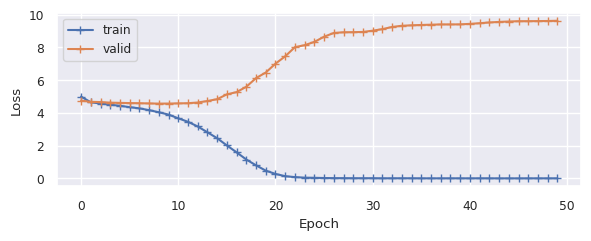

In [51]:
plt.figure(figsize=(6, 2.5))
for name, item in history.items():
    plt.plot(item, label=name, marker='+')
plt.legend()
#plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

Notice taht we have to use the `eval()` to disable random dropout.

In [54]:
question = 'What is the tallest mountain in the world?'
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
question_tok = tokenizer(
    question, padding=True, truncation=True, return_tensors='pt', max_length=64
).to(DEVICE)

with torch.no_grad():
    question_emb = qe.eval()(question_tok)[0]

print(question_emb[:5])

tensor([-0.5661, -0.5561,  0.2012,  0.0749, -0.7478], device='cuda:0')


Here we see the embedding of the paired QA are close

In [55]:
answers = [
    "What is the tallest mountain in the world?",
    "The tallest mountain in the world is Mount Everest.",
    "Who is donald duck?"
]
answer_emb = []

for answer in answers:
    tok = tokenizer(
        answer, padding=True, truncation=True, return_tensors='pt', max_length=64
    ).to(DEVICE)
    with torch.no_grad():
        emb = ae.eval()(tok)[0]
    answer_emb.append(emb)

for answer in answer_emb:
    print(answer @ question_emb)

tensor(11.2628, device='cuda:0')
tensor(9.2472, device='cuda:0')
tensor(-3.7265, device='cuda:0')


## Inference

### Dual Encoders for RAG

The <font color="teal"><b>Answer Encoder</b></font> is used in the <font color="teal"><b>ingest</b></font> process.

```{mermaid}
flowchart LR
    D[Documents]
    T([Text Extraction])
    C([Chunking])
    AE([Answer Encoder])
    V[(Vector DB)]
    D --> T --> C --> AE --> V
```

The <font color="blue"><b>Question Encoder</b></font> is used in the <font color="blue"><b>query</b></font> process.

```{mermaid}
flowchart LR
    F[Facts]
    UQ[User Query]
    R[Retrieval]
    L{{LLM}}
    QE([Question Encoder])
    V[(Vector DB)]
    UQ --> QE --> R --> V --> F --> L
    UQ --> L
```

### Similarity Search

Think of similarity as the inverse of a "distance". We want to find "close neighbours" for a given query.

The naive calculation can be slow, with a O(N) complexity. However, there are faster algorithms:

- HNSW
- Annoy
- FAISS
- NMSLib

In [56]:
import numpy as np

from sentence_transformers import SentenceTransformer
from transformers import (
    AutoTokenizer, DPRContextEncoder, DPRQuestionEncoder
)
import logging
logging.getLogger(
    "transformers.modeling_utils"
).setLevel(logging.ERROR)

In [57]:
def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    return rounded_similarity_matrix

### Using just a embedding model

If we use the same embedding model (encoder) for both the text chunk and user query, there is one possible issue.

The exact same questions are preferred by the similarity search, compared to the real answer!

In [59]:
answers = [
    "What is the tallest mountain in the world?",
    "The tallest mountain in the world is Mount Everest.",
    "Mount Shasta",
    "I like my hike in the mountains",
    "I am going to a yoga class"
]

question = 'What is the tallest mountain in the world?'

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
question_embedding = list(model.encode(question))

sim = []
for answer in answers:
    answer_embedding = list(model.encode(answer))
    sim.append(cosine_similarity_matrix(np.stack([question_embedding, answer_embedding]))[0,1])

print(sim)
best_inx = np.argmax(sim)
print(f"Question = {question}")
print(f"Best answer = {answers[best_inx]}")

[1.0, 0.7976, 0.4001, 0.3559, 0.0972]
Question = What is the tallest mountain in the world?
Best answer = What is the tallest mountain in the world?


### Using a Dual Encoder Model

We use the pre--trained [dual encoder model from facebook](https://huggingface.co/facebook/dpr-ctx_encoder-multiset-base) to demonstrate the same task.

This is the [paper for the model](https://arxiv.org/abs/2004.04906). 

In [60]:
answer_tokenizer = AutoTokenizer.from_pretrained(
    "./models/facebook/dpr-ctx_encoder-multiset-base"
)
answer_encoder = DPRContextEncoder.from_pretrained(
    "./models/facebook/dpr-ctx_encoder-multiset-base"
)
question_tokenizer = AutoTokenizer.from_pretrained(
    "./models/facebook/dpr-question_encoder-multiset-base"
)
question_encoder = DPRQuestionEncoder.from_pretrained(
    "./models/facebook/dpr-question_encoder-multiset-base"
)

In [62]:
# Compute the question embeddings
question_tokens = question_tokenizer(
    question, return_tensors="pt"
)["input_ids"]

question_embedding = question_encoder(
    question_tokens
).pooler_output.flatten().tolist()

sim = []
for answer in answers:
    answer_tokens = answer_tokenizer(
        answer, return_tensors="pt"
    )["input_ids"]
    answer_embedding = answer_encoder(
        answer_tokens
    ).pooler_output.flatten().tolist() 
    sim.append(
        cosine_similarity_matrix(
            np.stack([question_embedding, answer_embedding])
        )[0, 1]
    )

print(sim)
best_inx = np.argmax(sim)
print(f"Question = {question}")
print(f"Best answer = {answers[best_inx]}")

[0.6253, 0.7472, 0.5506, 0.3687, 0.25]
Question = What is the tallest mountain in the world?
Best answer = The tallest mountain in the world is Mount Everest.


## Extra Topics

### Two Stage Retrieval

Sentence transformers can be inaccurate. We can use a two--stage retrieval to improve.

```{mermaid}
flowchart LR
    A([DB]) --> B[embeddings\nrank by similarity] --> C[cross-encoder\nReranking] --> R[Result]
```

This is called **Retrieval** and **Rerank**.